In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [76]:
X_train =np.load('X_train.npy')
Y_train =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [122]:
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm = X_train_norm.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data = X_train_norm.copy()
train_data['Y_train'] = y_train_df.reset_index(drop=True)
train_data

,Air Temperature,Water Temperature,Wind speed,Wind Direction,Illumination,Y_train
0,0.381247,2.062005,0.378296,-0.393807,1.912646,-2.737384
1,-0.649277,-0.818513,2.165169,0.204288,-1.004879,-0.410969
2,-1.030509,-0.806199,-0.143433,-0.002829,-1.177856,14.833533
3,-1.930055,-0.942637,-1.331726,-0.966561,-1.733425,3.960804
4,0.939597,0.603392,-2.257478,-1.753702,0.944511,10.400393
...,...,...,...,...,...,...
195,0.377893,1.377785,0.457462,2.182375,1.451819,-2.356786
196,-0.240140,0.336880,-0.289301,1.212552,0.294484,-0.679252
197,1.040903,0.378041,-0.261347,-0.551529,0.842015,-2.202706
198,0.335330,0.772736,-0.675532,0.118341,0.806821,9.637862


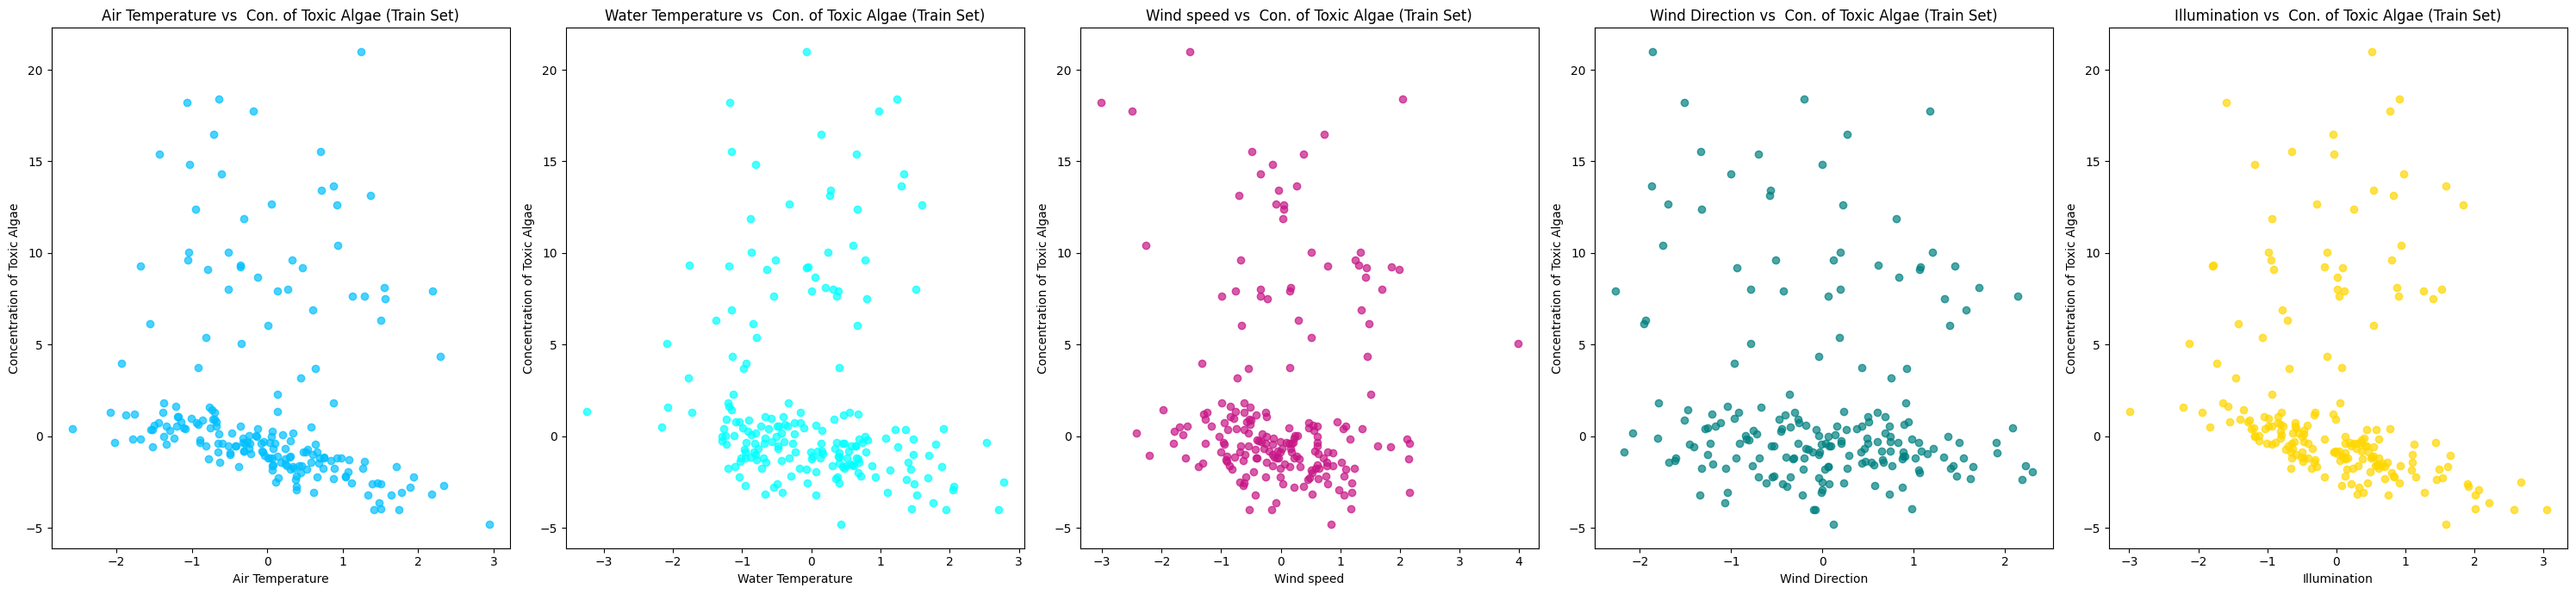

In [131]:
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(X_train_norm[feature], Y_train, alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

"Those variables are often affected by two main types of noise: (i) instrument noise η, which researchers have found to be well approximated by a zero mean white Gaussian noise, and (ii) human error ξ in handling the instruments and the resulting data, which researchers cannot precisely model but usually results in larger errors than instrument noise. Human error has been found to affect about 25% of the samples of the dependent variables, but it is negligible in the measurement of the independent variables." As such, the effects of the human error, that is the major source of error, are only visible in the dependent variable - Concentration of Toxic Algae. Let us focus on that variable to identify and exclude the outliers. To visualize the data, we show an histogram and a box plot. 

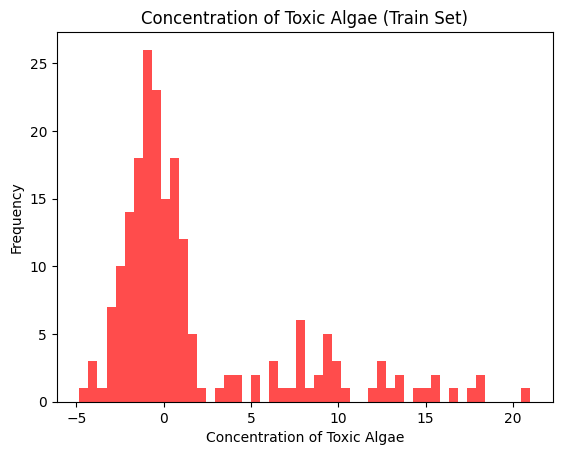

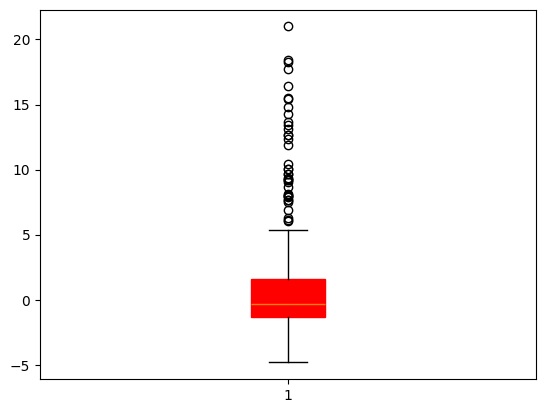

Multiplier: 1.5, Outlier Percentage: 19.50%
Multiplier: 1.4, Outlier Percentage: 19.50%
Multiplier: 1.2999999999999998, Outlier Percentage: 20.00%
Multiplier: 1.1999999999999997, Outlier Percentage: 21.00%
Multiplier: 1.0999999999999996, Outlier Percentage: 21.00%
Multiplier: 0.9999999999999997, Outlier Percentage: 21.00%
Multiplier: 0.8999999999999997, Outlier Percentage: 23.00%
Multiplier: 0.7999999999999997, Outlier Percentage: 24.00%
Multiplier: 0.6999999999999997, Outlier Percentage: 25.00%

Final Multiplier: 0.6999999999999997
Number of outliers: 50
Outlier Percentage: 25.00%


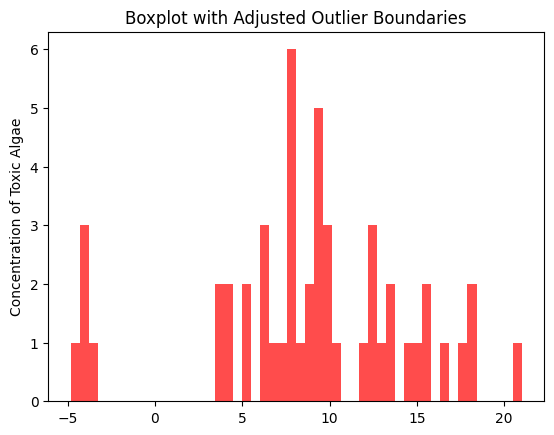

In [158]:
plt.hist(Y_train, bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.xlabel('Concentration of Toxic Algae')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(Y_train,patch_artist=True,boxprops=dict(facecolor='red', color='red'))
plt.show()

def calculate_outliers(multiplier):
    Q1 = train_data['Y_train'].quantile(0.25)
    Q3 = train_data['Y_train'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = train_data['Y_train'][(train_data['Y_train'] < lower_bound) | (train_data['Y_train'] > upper_bound)]
    return outliers

target_percentage = 0.25
multiplier = 1.5
step = 0.1

while True:
    outliers = calculate_outliers(multiplier)
    outlier_percentage = len(outliers) / len(train_data['Y_train'])
    print(f"Multiplier: {multiplier}, Outlier Percentage: {outlier_percentage:.2%}")
    
    if outlier_percentage >= target_percentage:
        break
    multiplier -= step

print(f"\nFinal Multiplier: {multiplier}")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier Percentage: {outlier_percentage:.2%}")

plt.hist(outliers, bins=50, color='red', alpha=0.7)
plt.title('Boxplot with Adjusted Outlier Boundaries')
plt.ylabel('Concentration of Toxic Algae')
plt.show()
